In [21]:
# coding=utf-8
"""
Bradbury M, Leeke M, Jhumka A. A dynamic fake source algorithm for source location privacy in wireless sensor networks[C].
    In: Proceedings of 2015 IEEE in Trustcom/BigDataSE/ISPA. 2015
"""
from cpsNode import *
from cpsLink import *
from cpsNetwork import *
from cpsAttacker import *
import Queue

class dynamicFSS:

    def __init__(self, G=cpsNetwork(nodeNumber=10, areaLength=20, initEnergy=1e6, radius=50),
                 Tmax=1000, sink_pos=(0,0), source_pos=(250, 250)):
        """
        实例初始化
        :param G: 
        :param Tmax: 
        :param sink_pos: 
        :param source_pos: 
        """
        if G.__class__ == 'Network from csv file'.__class__:
            self.G = cpsNetwork()
            self.G.read_csv(G)
        else:
            self.G = G

        self.Tmax = Tmax

        self.sink = -1
        self.sink_pos = sink_pos
        self.source = -1
        self.source_pos = source_pos

        self.attacker = cpsAttacker()

        self.safety = -1
        self.listDelay = []
        self.listEnergyConsumption = []

        self.path = []

    def display(self):
        print "节点总数：", self.G.nodeNumber
        print "正方形区域边长：", self.G.areaLength
        print "节点初始能量：", self.G.initEnergy
        print "节点通信半径：", self.G.radius
        print "sink：", self.sink, self.sink_pos
        print "source：", self.source, self.source_pos

    def display_results(self):
        print "安全周期数：", self.safety
        print "每一个周期的最大时延：", max(self.listDelay) if self.listDelay else 0
        print "每一个周期的最大能耗：", max(self.listEnergyConsumption) if self.listEnergyConsumption else 0
        id, maxEC = -1, 0
        for Node in self.G.nodeList:
            ec = min(self.G.initEnergy-Node.energy, self.G.initEnergy)
            if maxEC < ec:
                maxEC = ec
                id = Node.identity
        if id != -1:
            print "能耗最大的节点：", id, maxEC
        else:
            print "一切都好好的，节点的能量都满满的"

    def generateSINKandSOURCE(self):
        "部署 sink 和 source"
        self.sink = self.G.nodeNumber
        self.source = self.G.nodeNumber+1
        sinkNode = cpsNode(identity=self.sink, position=self.sink_pos, energy=self.G.initEnergy*100,
                           radius=self.G.radius, state='SINK', adj=set())
        sourceNode = cpsNode(identity=self.source, position=self.source_pos, energy=self.G.initEnergy*100,
                             radius=self.G.radius, state='SOURCE', adj=set())
        num = self.G.nodeNumber
        self.G.addNode(sinkNode)
        self.G.addNode(sourceNode)
        if self.G.nodeNumber != num+2:
            print "Error in the deployed sink and source."
            while len(self.G.nodeList) > num:
                self.G.nodeList.pop()
        else:
            for i in self.G.nodeList[self.sink].adj:
                self.G.nodeList[i].adj.add(self.sink)
            for i in self.G.nodeList[self.source].adj:
                self.G.nodeList[i].adj.add(self.source)

    def deployAttacker(self, Node):
        """部署攻击者初始位置"""
        self.attacker.initDeploy(Node)

    def levelSourceSink(self):
        "构建网络层次: hops to source then hops to sink"
        firstHop = np.zeros(self.G.nodeNumber, dtype=np.int)
        # hops to source
        hop2Source = np.ones(self.G.nodeNumber, dtype=np.int) * (-1)
        queue = Queue.Queue()
        visited = np.zeros(self.G.nodeNumber, dtype=np.int8)
        src = self.source
        hop2Source[src] = 0
        queue.put(src)
        visited[src] = 1
        while not queue.empty():
            u = queue.get()
            visited[u] = 0
            U = self.G.nodeList[u]
            for v in U.adj:
                V = self.G.nodeList[v]
                if hop2Source[v] == -1 or hop2Source[u] + 1 < hop2Source[v]:
                    hop2Source[v] = hop2Source[u] + 1
                    # update firstHop
                    firstHop[v] = hop2Source[v] if firstHop[v] == 0 else firstHop[v]
                    if visited[v] == 0:
                        queue.put(v)
                        visited[v] = 1
        # hops to sink
        hop2Sink = np.ones(self.G.nodeNumber, dtype=np.int) * (-1)
        queue = Queue.Queue()
        visited = np.zeros(self.G.nodeNumber, dtype=np.int8)
        src = self.sink
        hop2Sink[src] = 0
        queue.put(src)
        visited[src] = 1
        while not queue.empty():
            u = queue.get()
            visited[u] = 0
            U = self.G.nodeList[u]
            for v in U.adj:
                V = self.G.nodeList[v]
                if hop2Sink[v] == -1 or hop2Sink[u] + 1 < hop2Sink[v]:
                    hop2Sink[v] = hop2Sink[u] + 1
                    if visited[v] == 0:
                        queue.put(v)
                        visited[v] = 1
        # copy to cpsNode [hop2Source, hop2Sink, firstHop]
        for node in self.G.nodeList:
            self.G.nodeList[node.identity].level = [hop2Source[node.identity], hop2Sink[node.identity],
                                                    firstHop[node.identity]]
        return max(firstHop)

    def fakeSourceSelection(self, Ti, firstHopMAX):
        """
        temporary fake sources 和 permanent fake sources flooding fake messages
        :param Ti: 周期数
        :return: self.G.nodeList.state, self.G.nodeList.weight => 'TFS'/'PFS', (Duration, Period)
        """
        if Ti == 1:
            FS = [node.identity for node in self.G.nodeList if node.level[1] == 1]
            for v in FS:
                self.G.nodeList[v].state = 'TFS'
                self.G.nodeList[v].weight = (0.5, 2)
        else:
            preFS = [node.identity for node in self.G.nodeList if node.state == 'TFS']
            for u in preFS:
                for v in self.G.nodeList[u].adj:
                    if v not in preFS and self.G.nodeList[v].state == 'NORMAL' \
                            and self.G.nodeList[v].level[0] > 0.8*self.G.nodeList[self.sink].level[0]:
                        if self.G.nodeList[v].level[2] >= firstHopMAX-1:
                            self.G.nodeList[v].state = 'PFS'
                            self.G.nodeList[v].weight = (self.Tmax, 1)
                        else:
                            self.G.nodeList[v].state = 'TFS'
                            self.G.nodeList[v].weight = (1.0, 2*self.G.nodeList[v].level[1])
            for u in preFS:
                self.G.nodeList[u].state = 'NORMAL'

    def updateAdjMatrix(self):
        """
        更新通信关系矩阵，即建立 'TFS'/'PFS' 与其他节点间的通信关系
        :param self.G.adjacentMatrix: 通信关系矩阵
        :return: self.G.adjacentMatrix
        """
        self.G.initAdjMatrix()
        for node in self.G.nodeList:
            if node.state == 'TFS' or node.state == 'PFS':
                u = node.identity
                queue = Queue.Queue()
                visited = np.zeros(self.G.nodeNumber, dtype=np.int8)
                queue.put(u)
                visited[u] = 1
                while not queue.empty():
                    u = queue.get()
                    for v in self.G.nodeList[u].adj:
                        if visited[v] == 0:
                            self.G.adjacentMatrix[u,v] += node.weight[1]
                            queue.put(v)
                            visited[v] = 1

    def sendSource2Sink(self, Ti):
        """ TO DO SOMETHING
        一个周期内容事件：
        1）主要事件：源节点（包含分支上的虚假源）发送消息，并通过路径传输至基站
        输入参数：
        1）网络的链接矩阵 G.adjacentMatrix
        更新的参数：
        1）节点剩余能量
        2）攻击者位置
        返回值：
        1）源节点是否被捕获
        2）源节点消息上传到基站的时间花费
        3）网络能耗
        :param Ti: 周期数
        :return: flag, delayTi, energyTi(MAX) 
        """
        flag = False
        packetSize = 500 * 8 # 单次数据包大小 bit
        # 路由时延
        delays  = np.ones(self.G.nodeNumber, dtype=np.float)*np.inf
        visited = np.zeros(self.G.nodeNumber, dtype=np.int8)
        queue   = Queue.Queue()
        queue.put(self.source)
        delays[self.source]  = 0
        visited[self.source] = 1
        while not queue.empty():
            u = queue.get()
            for v in self.G.nodeList[u].adj:
                d = self.G.delayModelusingAdjMatrix(u, v)
                if delays[v] == np.inf or delays[v] > delays[u] + d:
                    if delays[v] == np.inf:        # source floods to sink 产生的通信链路
                        self.G.adjacentMatrix[u,v] = self.G.adjacentMatrix[u,v] + 1
                    delays[v] = delays[u] + d
                    if visited[v] == 0:
                        queue.put(v)
                        visited[v] = 1
        delayTi = delays[self.sink] * packetSize
        # 网络能耗 self.G.energyModelusingAdjMatrix()
        energyTi = 0
        for Node in self.G.nodeList:
            ec = self.G.energyModelusingAdjMatrix(Node)
            ec *= packetSize
#             print 'ec:', ec
            energyTi += ec
            self.G.nodeList[Node.identity].energy -= ec
            if Node.identity != self.sink and Node.identity != self.source \
                and self.G.nodeList[Node.identity].energy < self.G.initEnergy * 0.05:
                print 'Node %d run out: %d(%d)' % (Node.identity, self.G.nodeList[Node.identity].energy, self.G.initEnergy)
                flag = True
        self.attacker.move(self.G)
        if self.attacker.position.identity == self.source:
            flag = True
        print '[%d] flag: %d, delayTi: %d, energyTi: %d' % (Ti, flag, delayTi, energyTi)
        return flag, delayTi, energyTi

    def algDynamicFSS(self):
        """
        动态虚假源选择算法的主函数
        1）虚假源节点选择，包含 TFS 和 PFS
        2）更新当前轮的通信矩阵
        3）源节点向基站发送消息
        :return: 
        """
        firstHopMAX = self.levelSourceSink()
        for Ti in range(1, self.Tmax+1):
            if Ti % 100 == 0:
                print Ti
            elif Ti % 10 == 0:
                print Ti,
            print 'Select fake source ...'
            self.fakeSourceSelection(Ti, firstHopMAX)
            print 'Update AdjMatrix ...'
            self.updateAdjMatrix()
            print 'Send source data to sink ...'
            flag, delayTi, energyTi = self.sendSource2Sink(Ti)
            self.listDelay.append(delayTi)
            self.listEnergyConsumption.append(energyTi)
            if flag or Ti == self.Tmax:
                self.safety = Ti
                break

In [22]:
if __name__ == '__main__':
    dFFS = dynamicFSS(G='load_network/network.csv', sink_pos=(-200,-200), source_pos=(200,200))
    # print ""
    dFFS.generateSINKandSOURCE()
    dFFS.display()
    # print ""
    # dFFS.G.nodeList[dFFS.sink].display()
    # print ""
    # dFFS.G.nodeList[dFFS.source].display()

    dFFS.deployAttacker(dFFS.G.nodeList[dFFS.sink])
    dFFS.attacker.display()

    dFFS.levelSourceSink()
    dFFS.display()

    dFFS.algDynamicFSS()

节点总数： 3002
正方形区域边长： 500.0
节点初始能量： 1000000000.0
节点通信半径： 15.0
sink： 3000 (-200, -200)
source： 3001 (200, 200)
Node 3000 : (-200, -200) 1e+11 15.0 SINK
The weight is -1
The level is 0
Its neighbors are [128, 1216, 195, 2032, 1386, 368, 1874, 790, 730, 59]
The trace is [3000]
节点总数： 3002
正方形区域边长： 500.0
节点初始能量： 1000000000.0
节点通信半径： 15.0
sink： 3000 (-200, -200)
source： 3001 (200, 200)
Select fake source ...
Update AdjMatrix ...
Send source data to sink ...
[1] flag: 0, delayTi: 74841330, energyTi: 37418189000
Select fake source ...
Update AdjMatrix ...
Send source data to sink ...
[2] flag: 0, delayTi: 66299715, energyTi: 104019913000
Select fake source ...
Update AdjMatrix ...
Send source data to sink ...
[3] flag: 0, delayTi: 88766412, energyTi: 49807050000
Select fake source ...
Update AdjMatrix ...
Send source data to sink ...
Node 82 run out: -133039000(1000000000)
Node 128 run out: -359752000(1000000000)
Node 425 run out: -239576000(1000000000)
Node 474 run out: -81928000(1000000000)
No

4 1000


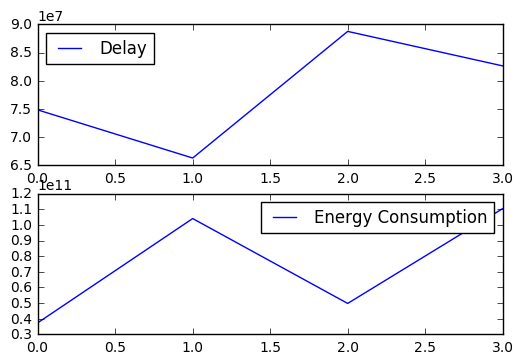

1541925000.0


In [23]:
import matplotlib.pyplot as plt
print dFFS.safety, dFFS.Tmax
plt.subplot(211)
plt.plot(dFFS.listDelay)
plt.legend(['Delay'], loc=0)
plt.subplot(212)
plt.plot(dFFS.listEnergyConsumption)
plt.legend(['Energy Consumption'], loc=0)
plt.show()
ecs = [dFFS.G.initEnergy-node.energy for node in dFFS.G.nodeList if node.identity != dFFS.sink and node.identity != dFFS.source]
print max(ecs)

In [29]:
t = [[node.identity, node.weight[1]] for node in dFFS.G.nodeList if node.state == 'TFS' or node.state == 'PFS']
print t 
a = 0
for ts in t:
    a += ts[1]
print a

[[70, 1], [170, 8], [355, 1], [503, 8], [614, 8], [696, 8], [705, 1], [770, 8], [790, 2], [798, 4], [805, 4], [811, 8], [917, 8], [933, 8], [1093, 4], [1094, 8], [1122, 8], [1309, 8], [1318, 4], [1401, 4], [1416, 1], [1537, 4], [1571, 8], [1616, 4], [1643, 8], [1659, 4], [1669, 8], [1671, 8], [1685, 4], [1693, 8], [1746, 4], [1808, 8], [1944, 8], [1968, 4], [2024, 8], [2028, 8], [2094, 8], [2147, 8], [2221, 4], [2271, 8], [2299, 8], [2472, 8], [2648, 4], [2658, 4], [2704, 8], [2746, 8], [2786, 8], [2795, 8]]
294
